# Example: GLE dynamics using the atomic simulation environment (ASE) package

In this example we will set up a GLE simulation for a Pt(111) surface using the ASE package. 

We will assume GLE has been parametrized in such a way to allow surface sites to be effectively non-interacting.

In [1]:
from ase import units, Atoms
from ase.build import bulk, surface, fcc111
from ase.io import Trajectory
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution

import glepy.memory.time as memt
from glepy.ase.forcefield import ZeroPotential, Harmonic3D, MorseZ_MetalAdsorbate, GroupForcefield
from glepy.ase.dynamics import GLD, GLD_Aniso

import numpy as np
import matplotlib.pyplot as plt

def read_frck(file):
    """
    Read Potential of Mean Force from File
    """
    handle = open(file,'r')
    handle.readline()
    handle.readline()
    
    line = handle.readline()[2:-2]
    kx = np.fromstring(line,sep=" ")
    line = handle.readline()[2:-2]
    ky = np.fromstring(line,sep=" ")
    line = handle.readline()[2:-3]
    kz = np.fromstring(line,sep=" ")
    
    frck = np.array([kx,ky,kz])
    return frck

We start by setting up the system and parsing the $A$ matrix from the appropriate file

In [2]:
##### Constants and Conversion Factors

kbT_eV = 0.02585  # 300K in eV
radperps_to_cm = 33.356 * 1.0/(2*np.pi) #rad/ps to cm-1
units_ps = units.fs * 1e3 # ps to ase time units

##### Script Parameters

# Input File Arguments
A_file     = "Kz_5term.A"
K_file     = "frck.dat"

# Simulation Arguments
eq_steps    = 20000    # Equilibriation Steps
run_steps   = 500000   # Production Steps
temp        = 300      # Temperature
dt          = 1.0      # Timestep in femtoseconds
interval    = 5       # interval for writing out data

# Lattice Arguments
lattice_ele = "Pt"       # Lattice Element
Nx, Ny, Nz = 1,1,1

# Load GLE parameters, convert to ASE (metal) units
Amat = np.loadtxt(A_file, delimiter=None)/units_ps

# Load harmonic force constants, convert to ASE (metal) units
frc_k = read_frck(K_file) * (units.kJ/units._Nav)

Now we run the simulation

In [3]:
##### Create Simulation System

# Create Lattice 
Natom = Nx * Ny * Nz
atoms = fcc111('Pt', size=(Nx, Ny, Nz))
atoms.center(axis=2, vacuum = 10)
atoms.translate([0, 0, -10])
atoms.pbc=(True, True, False)

# Set up Calculators
pos_0 = atoms.positions.copy()
calc = Harmonic3D(frc_k, atoms.positions.copy(), np.diag(atoms.get_cell()) )
atoms.calc   = calc

##### Run NVT/Equilibriation Step

# Set the momenta corresponding to T=300K
MaxwellBoltzmannDistribution(atoms, temperature_K=temp)

# Run Simulation
print("Running Equilibriation")
dyn_eq = GLD(atoms, dt*units.fs, Amat, Amat_units="ase", temperature_K=temp, int_type=1)
dyn_eq.run(eq_steps)

##### Run Production Simulation
print("Running Production")
dyn = GLD(atoms, dt*units.fs, Amat, Amat_units="ase", temperature_K=temp, int_type=1)
traj = Trajectory("md.traj",'w', atoms)
dyn.attach(traj.write, interval=interval)
dyn.run(run_steps)

##### End of Run File I/O

print("Loading Data")

# Load trajectory
traj_sim = Trajectory("md.traj", 'r')

pos_array = []
vel_array = []
frc_array = []

for atoms in traj_sim:
    pos = atoms.get_positions()
    vel = atoms.get_velocities()
    frc = atoms.get_forces()
    
    pos_array.append(pos)
    vel_array.append(vel)
    frc_array.append(frc)
    
# Convert units back to MD(Gromacs units)
pos_array = np.array(pos_array) / (units.nm)
vel_array = np.array(vel_array) / (units.nm / (units.fs * 1e3) )
frc_array = np.array(frc_array) / (units.kJ/units._Nav/units.nm)

print("Done")

Running Equilibriation
Running Production
Loading Data
Done


Now we extract the memory kernel and compare to the input

Ave Temp = 2.7004 kJ/mol = 324.7908 Kelvin
Spring Constant calc: 
 [[102.836  -5.29   -0.923]
 [ -5.29  167.991   2.849]
 [ -0.923   2.849 289.978]]
Spring Constant inpt 
 [[ 99.   -4.9  -0.6]
 [ -4.9 152.6   0. ]
 [ -0.6   0.  308. ]]
calculating velocity tcfs
calculating force tcfs


/Users/ardavan/miniconda3/envs/ase_x86/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


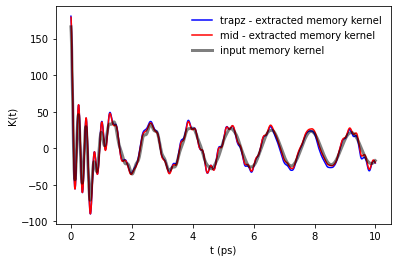

In [4]:
##### Extract Memory

def harm3D(x, xeq, frck):
    """
    3D anisotropic harmonic potential.
    """
    x = (x - xeq)
    frc =  - np.einsum("ij,tdj->tdi",frck,x)
    return frc
    
# Atom parameters
nsys = len(atoms)
m = atoms.get_masses()[0]

# Calculate averate temperature
kbT_traj = m/3 * np.sum( np.mean( vel_array**2, axis=1), axis=1)
kbT = kbT_traj.mean()
print("Ave Temp = %4.4f kJ/mol = %4.4f Kelvin"%(kbT, 120.2731 * kbT))

# Calculate Force Constants
pos_mean = pos_array.mean(axis=0)

frck_md = []
for i in range(nsys):
    frck_md.append( kbT * np.linalg.inv( np.cov( pos_array[:,i,:],rowvar=False) ) )
frck_md = np.array(frck_md).mean(axis=0)

print("Spring Constant calc: \n", frck_md.round(1)/100)
print("Spring Constant inpt \n",   frc_k / (units.kJ/units._Nav) )

dpmf = harm3D(pos_array, pos_mean, frc_k / (units.kJ/units._Nav)*100)

dt_md = dt/1000
stride = interval
tcorr = 2000

pos = pos_array.reshape(-1,nsys*3)
vel = vel_array.reshape(-1,nsys*3)
frc = frc_array.reshape(-1,nsys*3)
acc = np.gradient(vel, dt_md*stride, axis=0)
dpmf = dpmf.reshape(-1,nsys*3)

tarr = np.arange(tcorr)*dt_md*stride
tarr_mid = (tarr[1:]+tarr[0:-1])/2.0

# Calculate Correlation Functions
print("calculating velocity tcfs")
vel_tcf  = memt.calc_tcf(vel, vel, max_t=tcorr, mode="scipy")[:,2::3].mean(axis=-1)
dvel_tcf = -memt.calc_tcf(vel, acc, max_t=tcorr, mode="scipy")[:,2::3].mean(axis=-1)

print("calculating force tcfs")
frc_tcf      =  memt.calc_tcf(acc - dpmf/m, vel, max_t=tcorr, mode="scipy")[:,2::3].mean(axis=-1)
dfrc_tcf     = -memt.calc_tcf(acc - dpmf/m, acc, max_t=tcorr, mode="scipy")[:,2::3].mean(axis=-1)

# Memory Kernels - Different Methods
Ktrap = memt.calc_memory_dtrapz(dvel_tcf, dfrc_tcf, vel_tcf[0], dt_md*stride)
Kmid = memt.calc_memory_midpt(vel_tcf, frc_tcf, dt_md*stride)
Kfft = memt.calc_memory_fft(vel_tcf, frc_tcf, dt_md*stride)

# True Memory Kernel
Amat_cnvrt = Amat * (units.fs * 1e3)
As  = Amat_cnvrt[1:,1:]
Asv = Amat_cnvrt[1:,0:1]
Avs = Amat_cnvrt[0:1,1:]
Kt_inp = -Avs @  memt.matrixexp(-As,tarr, Hermitian=False) @ Asv
Kt_inp = Kt_inp[:,0,0]

plt.figure()
plt.plot(tarr, Ktrap, color="b", label="trapz - extracted memory kernel")
plt.plot(tarr_mid,Kmid, color="r", label="mid - extracted memory kernel")
plt.plot(tarr, Kt_inp, color="k", linewidth=3.0, alpha=0.5, label="input memory kernel")
plt.xlabel("t (ps)")
plt.ylabel("K(t)")
plt.legend(frameon=False)

Better sampling (longer simulation) leads to better agreement. 